In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import time
import torch
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import torch.optim as optim
from torch.optim import lr_scheduler
# from torch import nn
from copy import deepcopy

In [3]:
from spacetime import SpaceTime
from spacetime.metrics import count_accuracy
from spacetime.models import MLPEncoder, MLPDecoder
from spacetime.training import train, _h_A, _h_A_ordered
from spacetime.utils import arguments, nbins, torch_graph, torch_loader

In [4]:
args = arguments(node_dict = {0:[0], 1:[1], 2:[2], 3:[3]})
args.data_sample_size=10000
args.noise_scale = 0.6
args.graph_type='erdos-renyi'
args.graph_sem_type='linear-gauss'
args.graph_linear_type='nonlinear_2'
args.graph_degree = 2

# training hyperparameters
args.graph_threshold=0.3  # 0.3 is good 0.2 is error prune
args.tau_A=1e-10
args.ordered_graph=True
args.use_A_connect_loss=False
args.use_A_positiver_loss=False

args.seed=42
args.epochs=5
args.batch_size=100 # note: should be divisible by sample size otherwise throw an error
args.encoder_hidden=64
args.decoder_hidden=64

simulating an ordered 2-degree erdos-renyi dag with range (0.5, 2.0) (seed 101)
simulating 10000 samples from a linear-gauss sem with nonlinear_2 causal effects


array([[ 0.   ,  1.84 , -1.582,  0.785],
       [ 0.   ,  0.   ,  0.773,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ]])

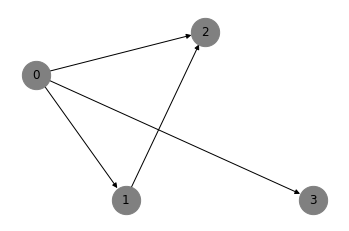

In [5]:
g = SpaceTime.from_spacetime(args.node_dict, simulate=True,
                             degree=args.graph_degree, graph_type=args.graph_type, 
                             w_range=(0.5,2.0), force_positive=True, seed=101)
g.graph.edges[(0,1)]['weight'] *= 1.0
g.graph.edges[(0,2)]['weight'] *= -1.0
g.graph.edges[(0,3)]['weight'] *= 1.0
g.graph.edges[(1,2)]['weight'] *= 1.0
g.generate_data(n=args.data_sample_size, x_dims=args.x_dims, 
                sem_type=args.graph_sem_type, linear_type=args.graph_linear_type, 
                noise_scale=args.noise_scale, seed=args.seed)
g.show_adj()
g.draw_graph()

In [6]:
train_loader, test_loader = torch_loader(g.data, args.batch_size)
shd_train = []

t_total = time.time()

best_ELBO_loss = np.inf
best_epoch = 0
best_ELBO_graph = None

best_NLL_loss = np.inf
best_NLL_graph = None

# optimizer step on hyparameters
c_A = args.c_A
lambda_A = args.lambda_A
h_A_new = torch.tensor(1.)
h_tol = args.h_tol
k_max_iter = int(args.k_max_iter)
h_A_old = np.inf

#===================================
# load modules
#===================================
# add adjacency matrix A
num_nodes = args.data_variable_size
adj_A = np.zeros((num_nodes, num_nodes))

encoder = MLPEncoder(args.data_variable_size*args.x_dims, args.x_dims, 
                     args.encoder_hidden, int(args.z_dims), adj_A).double()

decoder = MLPDecoder(args.data_variable_size*args.x_dims, args.z_dims, 
                     args.x_dims, n_hid=args.decoder_hidden).double()

#===================================
# set up training parameters
#===================================
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),lr=args.lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=args.lr_decay, gamma=args.gamma)

#===================================
# train model
#===================================

for step_k in range(k_max_iter):
    while c_A < 1e+20:
        for epoch in range(args.epochs):
            ELBO_loss, NLL_loss, graph, origin_A = train(lambda_A, c_A, optimizer, scheduler, 
                                                         encoder, decoder, train_loader, args)
            
            fdr, tpr, fpr, shd, nnz = count_accuracy(g.show_adj(around=10), graph)
            shd_train.append(shd)

            if ELBO_loss < best_ELBO_loss:
                best_ELBO_loss = ELBO_loss
                best_epoch = epoch
                best_ELBO_graph = graph

            if NLL_loss < best_NLL_loss:
                best_NLL_loss = NLL_loss
                best_epoch = epoch
                best_NLL_graph = graph

        print("Optimization Finished!")
        print("Best Epoch: {:04d}\t".format(best_epoch),
              "Best ELBO: {:.10f}".format(best_ELBO_loss),
              "Best NLL: {:.10f}".format(best_NLL_loss))
        if ELBO_loss > 2 * best_ELBO_loss:
            break

        # update parameters
        A_new = origin_A.data.clone()

        if args.ordered_graph:
            h_A_new = _h_A_ordered(A_new, args.node_dict)
        else:
            h_A_new = _h_A(A_new, args.data_variable_size)

        if h_A_new.item() > 0.25 * h_A_old:
            c_A*=10
        else:
            break

        # update parameters
        # h_A, adj_A are computed in loss anyway, so no need to store

    h_A_old = h_A_new.item()
    lambda_A += c_A * h_A_new.item()

    if h_A_new.item() <= h_tol:
        break

# test()
fdr, tpr, fpr, shd, nnz = count_accuracy(g.show_adj(around=10), best_ELBO_graph)

print('Best ELBO Graph Accuracy: fdr', fdr, ' tpr ', tpr, ' fpr ', fpr, 'shd', shd, 'nnz', nnz)
print(best_ELBO_graph)

print('Ground truth graph')
print(g.show_adj(around=10))

Optimization Finished!
Best Epoch: 0002	 Best ELBO: 0.0350856039 Best NLL: 0.0081772981
Optimization Finished!
Best Epoch: 0004	 Best ELBO: 0.0149350267 Best NLL: 0.0003245232
Optimization Finished!
Best Epoch: 0004	 Best ELBO: 0.0100892923 Best NLL: 0.0001056941
Optimization Finished!
Best Epoch: 0004	 Best ELBO: 0.0077406095 Best NLL: 0.0001012089
Optimization Finished!
Best Epoch: 0004	 Best ELBO: 0.0067088842 Best NLL: 0.0000676351
Optimization Finished!
Best Epoch: 0004	 Best ELBO: 0.0058870848 Best NLL: 0.0000535562
Optimization Finished!
Best Epoch: 0004	 Best ELBO: 0.0052965034 Best NLL: 0.0000425486
Optimization Finished!
Best Epoch: 0003	 Best ELBO: 0.0048990939 Best NLL: 0.0000425486
Optimization Finished!
Best Epoch: 0004	 Best ELBO: 0.0043290680 Best NLL: 0.0000413317
Optimization Finished!
Best Epoch: 0003	 Best ELBO: 0.0040262075 Best NLL: 0.0000413317
Optimization Finished!
Best Epoch: 0004	 Best ELBO: 0.0036509242 Best NLL: 0.0000282264
Optimization Finished!
Best Epoc

(array([100.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   4.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

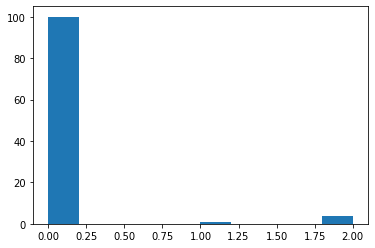

In [7]:
plt.hist(shd_train)

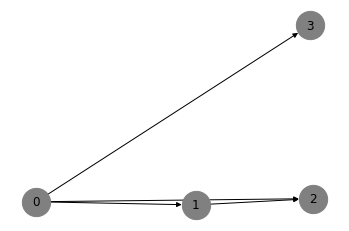

In [28]:
g_learned = SpaceTime.from_adjacency(best_ELBO_graph)
g_learned.draw_graph()

In [8]:
class graph_sampler:
    def __init__(self, graph, order, data, bin_width, discrete = False, noise=False):
        self.discrete = discrete
        self.noise = noise
        self.n = data.shape[0]
        self.n_vars = data.shape[1]
        
        self.graph = graph
        self.order = order
        self.data = np.squeeze(data)
        self.bin_width = bin_width
        
        self.nodes = tuple(reversed(range(self.n_vars)))
        self.joint, self.axes = self._compute_joint_full()
    
    def sample_at(self, prob, sample_dict):
        index = [slice(None)]*len(self.nodes)
        axes_dict = {i: sample_dict[node] for i, node in enumerate(self.nodes) 
                     if node in sample_dict.keys()}
        
        for axis, val in axes_dict.items():
            valbin = (np.abs(self.axes[axis] - val)).argmin()
            index[axis] = slice(valbin, valbin+1, 1)
        return prob[tuple(index)]
    
    def integrate_out(self, prob, *args):
        out_axes = [i for i, node in enumerate(self.nodes) if node in args]
        return np.sum(prob, axis=tuple(out_axes), keepdims=True)
    
    def get_axes(self, *args):
        ordered_axes = list(self.nodes)
        permutation = [ordered_axes.index(x) for x in args]
        return [self.axes[perm] for perm in permutation]
    
    def compute_joint(self, *args, sample_dict=dict()):
        nodes_out = [node for i, node in enumerate(self.nodes) if node not in args]
        
        _sample = lambda x: self.sample_at(x, sample_dict)
        _int = lambda x: self.integrate_out(x, *nodes_out)
        return _int(_sample(self.joint))
    
    def compute_conditional(self, var, *args, sample_dict=dict()):
        nodes_out = [x for x in self.nodes if x not in [var]+list(args)]
        
        _compute_num = lambda x: self.integrate_out(x, *nodes_out)
        _divide_den = lambda x: x/self._zero2epsilon(self.integrate_out(x, var))
        _sample = lambda x: self.sample_at(x, sample_dict)
        return _sample(_divide_den(_compute_num(self.joint)))
    
    def get_joint(self, *args, sample_dict=dict()):
        if any(x in args for x in sample_dict.keys()):
            raise ValueError("sample_dict keys cannot overlap with requested observables")
            
        ordered_axes = list(sorted(args[:], reverse=True))
        perm = [ordered_axes.index(x) for x in args]
        _reorder = lambda x: np.transpose(np.squeeze(x), tuple(perm))
        return _reorder(self.compute_joint(*args, sample_dict=sample_dict))
    
    def get_conditional(self, var, *args, sample_dict=dict()):
        if any(x not in args for x in sample_dict.keys()):
            raise ValueError("sample_dict keys must be from conditioned nodes")
        
        output_nodes = [var]+[x for x in args if x not in sample_dict]
        ordered_axes = list(sorted(output_nodes, reverse=True))

        perm = [ordered_axes.index(x) for x in output_nodes]
        _reorder = lambda x: np.transpose(np.squeeze(x), tuple(perm))
        return _reorder(self.compute_conditional(var, *args, sample_dict=sample_dict))
    
    def _zero2epsilon(self, arr):
        epsilon = 10e-10
        arr[arr==0] = epsilon
        return arr
            
    def _compute_joint_full(self):
        bins = [self._bin_boundaries(i) for i in self.nodes]
        joint, bnds = np.histogramdd(self.data[:, list(self.nodes)], bins=bins, density=True)
        joint /= np.sum(joint)
        axes = [bound[:-1]+np.diff(bound)/2 for bound in bnds]
        return joint, axes
    
    def _bin_boundaries(self, node):
        pad_lower = 0 if not self.discrete else -0.5
        pad_upper = 0 if not self.discrete else 1.5
        if not self.noise:
            ceil, floor =  np.ceil(self.data[:, node].max()), np.floor(self.data[:, node].min())
        else:
            ceil =  np.around(np.around(self.data[:, node].max(), 2)+10e-3, 2)
            floor = np.around(np.around(self.data[:, node].min(), 2)-10e-3, 2)
        boundaries = np.arange(floor+pad_lower, ceil+pad_upper, np.around((ceil-floor)/20, 3))
        return boundaries
    
    def get_plot_marginal(self, var):
        joint, axes = self.get_joint(var), self.get_axes(var)
        return axes[0], joint
    
    def get_contour_joint(self, var_x, var_y, sample_dict=dict()):
        joint = self.get_joint(var_x, var_y, sample_dict=sample_dict)
        axes = self.get_axes(var_x, var_y)
        mesh = np.meshgrid(*axes)
        return mesh[0], mesh[1], joint.T
    
    def get_contour_conditional(self, var, *args, sample_dict=dict()):
        conditional = self.get_conditional(var, *args, sample_dict=sample_dict)
        if len(conditional.shape) != 2:
            raise ValueError("contour requires a 2-d probability distribution")
        output_nodes = [var]+list(set(args)-set(sample_dict.keys()))

        axes = self.get_axes(*output_nodes)
        mesh = np.meshgrid(*axes)
        return mesh[0], mesh[1], conditional.T

In [9]:
def compute_mean_std(prob, axes):
    mean = prob.dot(axes)
    std = np.sqrt(prob.dot((mean-axes)**2))
    return mean, std

def sample_noise(N, sampler, mutilate = list()):
    z_syn_dict = dict()

    for t, xx in sampler.order.items():
        for x in xx:
            parents = list(sampler.graph.predecessors(x))

            if len(parents) == 0 or x in mutilate:
                mean, std = compute_mean_std(sampler.get_joint(x), sampler.get_axes(x)[0])
                z_syn_dict[x] = np.random.normal(mean, std, N)
            else:
                z_syn_list = list()
                for p in list(zip(*map(z_syn_dict.get, parents))):
                    sample_dict = dict(zip(parents, p))
                    mean, std = compute_mean_std(sampler.get_conditional(x,*parents, sample_dict=sample_dict),
                                                 sampler.get_axes(x)[0])
                    z_syn_list.append(np.random.normal(mean, std, 1)[0])
                z_syn_dict[x] = np.array(z_syn_list)
    return torch.FloatTensor(np.array(list(z_syn_dict.values())).T.reshape(N, len(z_syn_dict), 1))

simulating 10000 samples from a linear-gauss sem with nonlinear_2 causal effects


array([[ 0.   ,  1.84 , -1.582,  0.785],
       [ 0.   ,  0.   ,  0.773,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ]])

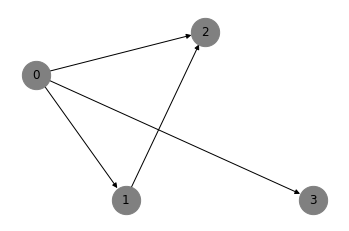

array([[ 0.   ,  0.   , -1.582,  0.785],
       [ 0.   ,  0.   ,  0.773,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ]])

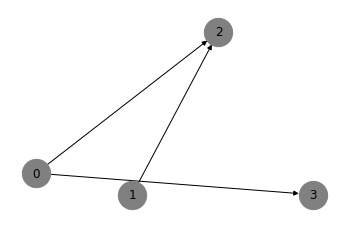

In [10]:
g_mutil = deepcopy(g)
g_mutil.graph.remove_edge(0,1)
g_mutil.generate_data(n=args.data_sample_size, x_dims=args.x_dims, 
                      sem_type=args.graph_sem_type, linear_type=args.graph_linear_type, 
                      noise_scale=args.noise_scale, seed=args.seed)
g.show_adj()
g.draw_graph()
g_mutil.show_adj()
g_mutil.draw_graph()

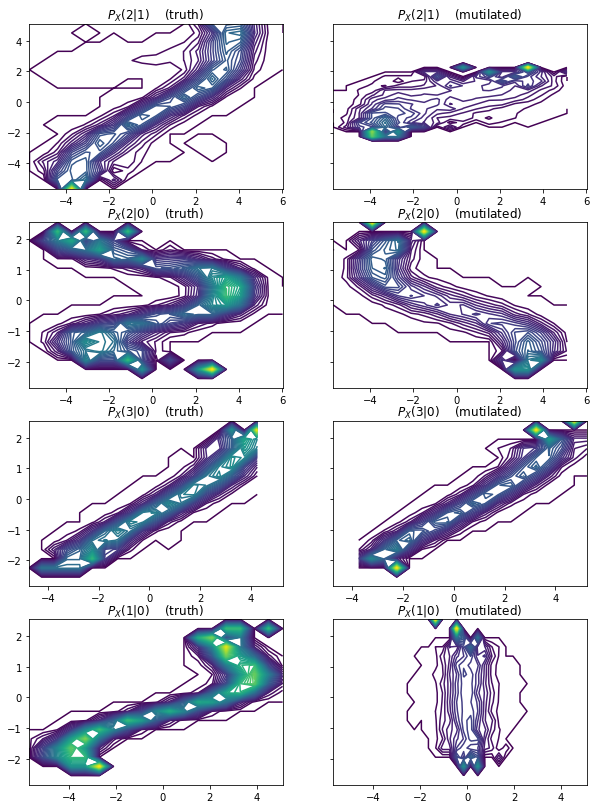

In [11]:
pX = graph_sampler(g.graph, g.order, g.data, 
                   bin_width=args.noise_scale, discrete=False, noise=False)
pX_mutil = graph_sampler(g_mutil.graph, g_mutil.order, g_mutil.data, 
                        bin_width=args.noise_scale, discrete=False, noise=False)

row_plot_dict = {0:(2,1), 1:(2,0), 2:(3,0), 3:(1,0)}

fig, axs = plt.subplots(4, 2, sharex='row', sharey='row', figsize = (10,14))
for row, (d,c) in row_plot_dict.items():
    axs[row][0].set_title(r'$P_X(%s|%s)$    (truth)'%(d,c))
    axs[row][0].contour(*pX.get_contour_conditional(d,c), levels=50)
    axs[row][1].set_title(r'$P_X(%s|%s)$    (mutilated)'%(d,c))
    axs[row][1].contour(*pX_mutil.get_contour_conditional(d,c), levels=50)
plt.show()

pass;

array([[ 0.   ,  3.097, -2.95 ,  1.679],
       [ 0.   ,  0.   ,  1.551,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ]])

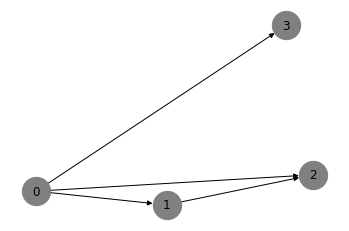

array([[ 0.   ,  0.   , -2.95 ,  1.679],
       [ 0.   ,  0.   ,  1.551,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ]])

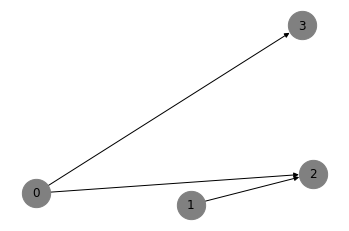

In [12]:
g_learned = SpaceTime.from_adjacency(best_ELBO_graph)
g_learned_mutil = deepcopy(g_learned)
g_learned_mutil.graph.remove_edge(0,1)

g_learned.show_adj()
g_learned.draw_graph()
g_learned_mutil.show_adj()
g_learned_mutil.draw_graph()

In [13]:
encoder.eval()
decoder.eval()
data = next(iter(test_loader))[0].double()
_, noise, _, _, _, _, Wa_train = encoder(data)
_, preds = decoder(noise, args.data_variable_size*args.x_dims, 
                   torch_graph(g_learned.show_adj(around=10)), Wa_train)
noise = noise.detach().numpy()
preds = preds.detach().numpy()

MLPEncoder(
  (fc1): Linear(in_features=1, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

MLPDecoder(
  (out_fc1): Linear(in_features=1, out_features=64, bias=True)
  (out_fc3): Linear(in_features=64, out_features=1, bias=True)
)

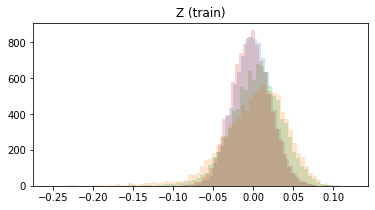

In [14]:
z_bins = 12
z_range_min = 100.0

fig, ax = plt.subplots(1, 1, sharex=True, figsize = (6,3))
ax.set_title(r'Z (train)')
for i in g_learned.graph.nodes:
    ax.hist(noise[:,i,:], alpha=0.2, bins=nbins(noise[:,i,:], 0.005))
    
    z_range = np.max(noise[:,i,:])-np.min(noise[:,i,:])
    if z_range < z_range_min:
        z_range_min = z_range

z_bin_width = np.around(z_range_min/z_bins, 2)
pass;

In [15]:
pZ = graph_sampler(g_learned.graph, g_learned.order, noise, 
                   bin_width=z_bin_width, discrete=False, noise=True)
pZ.joint.shape

(20, 19, 19, 19)

In [16]:
noise_synthetic = sample_noise(5000, pZ)
noise_synthetic_mutil = sample_noise(5000, pZ, mutilate=[1])

pZ_synthetic = graph_sampler(g_learned.graph, g_learned.order, noise_synthetic, 
                             bin_width=z_bin_width, 
                             discrete=False, noise=True)
pZ_synthetic_mutil = graph_sampler(g_learned.graph, g_learned.order, noise_synthetic_mutil, 
                                   bin_width=z_bin_width, 
                                   discrete=False, noise=True)

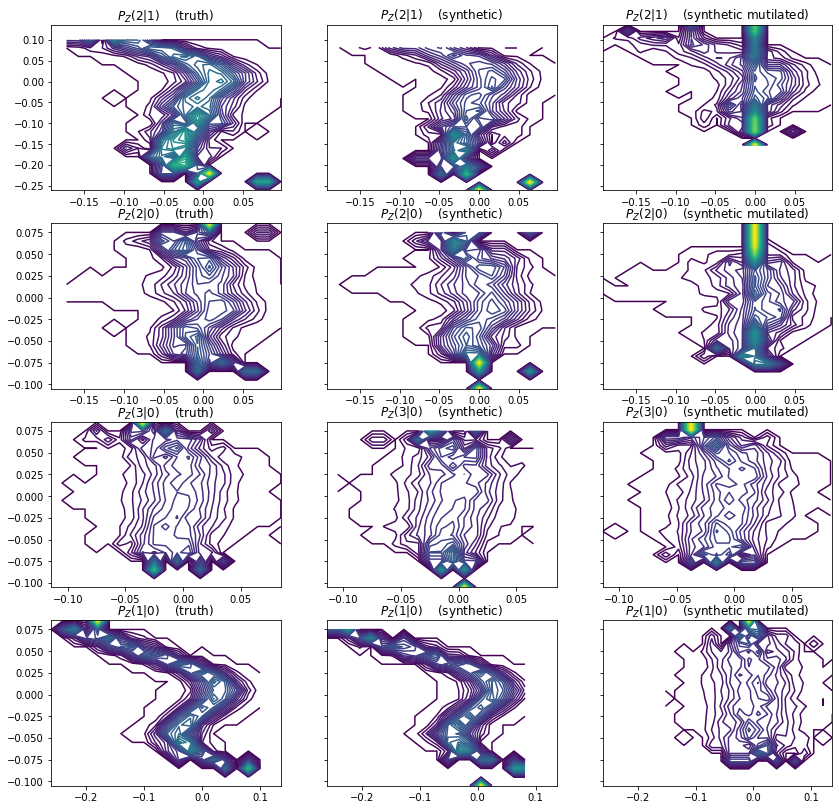

In [17]:
fig, axs = plt.subplots(4, 3, sharex='row', sharey='row', figsize = (14,14))
for row, (d,c) in row_plot_dict.items():
    axs[row][0].set_title(r'$P_Z(%s|%s)$    (truth)'%(d,c))
    axs[row][0].contour(*pZ.get_contour_conditional(d,c), levels=50)
    axs[row][1].set_title(r'$P_Z(%s|%s)$    (synthetic)'%(d,c))
    axs[row][1].contour(*pZ_synthetic.get_contour_conditional(d,c), levels=50)
    axs[row][2].set_title(r'$P_Z(%s|%s)$    (synthetic mutilated)'%(d,c))
    axs[row][2].contour(*pZ_synthetic_mutil.get_contour_conditional(d,c), levels=50)
plt.show()

pass;

In [18]:
pZ.joint.shape

(20, 19, 19, 19)

In [19]:
pX_generated = graph_sampler(g_learned.graph, g_learned.order, preds, 
                             bin_width=args.noise_scale, discrete=False, noise=False)

_, preds_synthetic = decoder(noise_synthetic, args.data_variable_size*args.x_dims, 
                             torch_graph(g_learned.show_adj(around=10)), Wa_train)
preds_synthetic = preds_synthetic.detach().numpy()
pX_synthetic = graph_sampler(g_learned.graph, g_learned.order, preds_synthetic, 
                             bin_width=args.noise_scale, discrete=False, noise=False)

_, preds_synthetic_mutil = decoder(noise_synthetic_mutil, args.data_variable_size*args.x_dims, 
                                   torch_graph(g_learned_mutil.show_adj(around=10)), Wa_train)
preds_synthetic_mutil = preds_synthetic_mutil.detach().numpy()
pX_synthetic_mutil = graph_sampler(g_learned_mutil.graph, g_learned_mutil.order, preds_synthetic_mutil, 
                                  bin_width=args.noise_scale, discrete=False, noise=False)

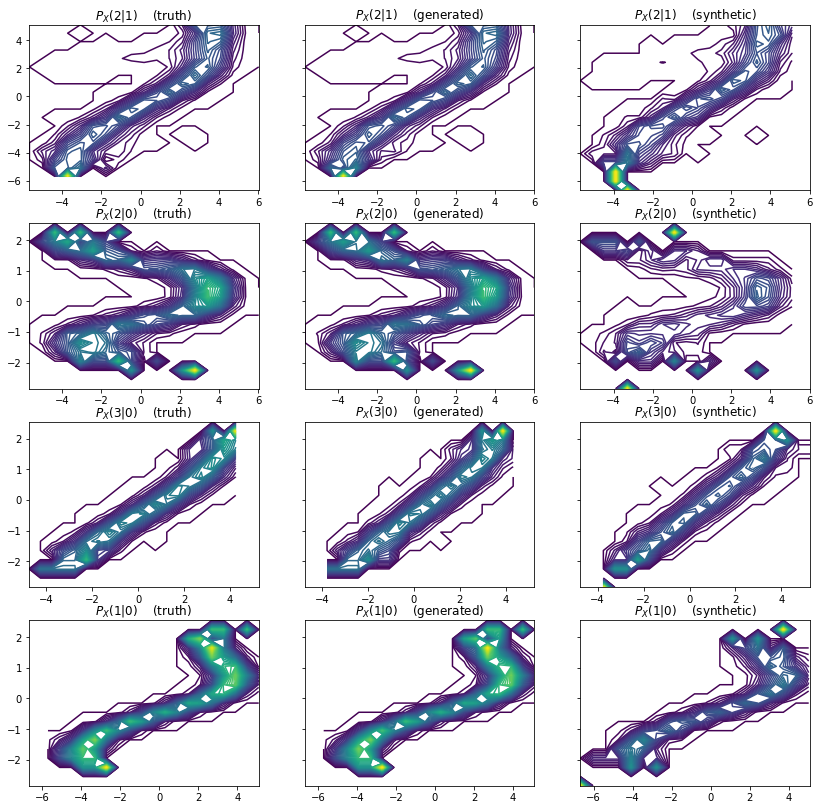

In [20]:
fig, axs = plt.subplots(4, 3, sharex='row', sharey='row', figsize = (14,14))
for row, (d,c) in row_plot_dict.items():
    axs[row][0].set_title(r'$P_X(%s|%s)$    (truth)'%(d,c))
    axs[row][0].contour(*pX.get_contour_conditional(d,c), levels=50)
    axs[row][1].set_title(r'$P_X(%s|%s)$    (generated)'%(d,c))
    axs[row][1].contour(*pX_generated.get_contour_conditional(d,c), levels=50)
    axs[row][2].set_title(r'$P_X(%s|%s)$    (synthetic)'%(d,c))
    axs[row][2].contour(*pX_synthetic.get_contour_conditional(d,c), levels=50)
plt.show()

pass;

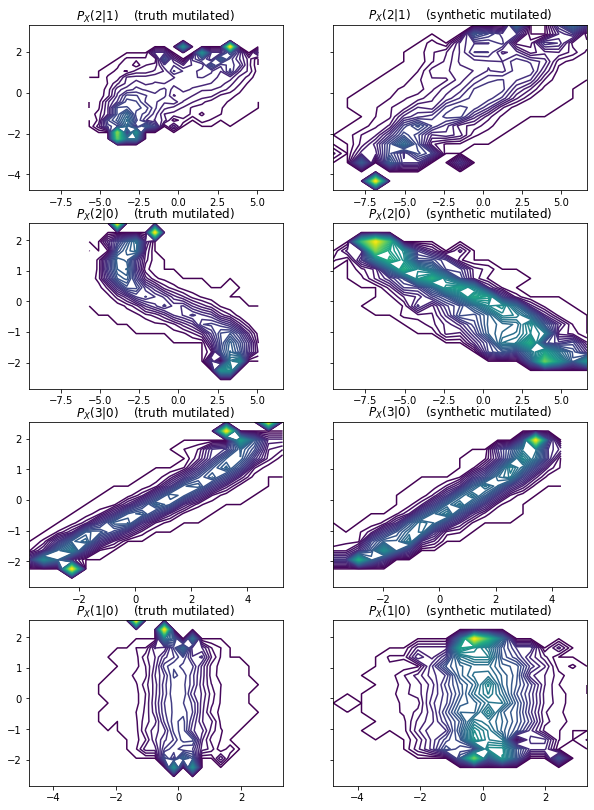

In [21]:
fig, axs = plt.subplots(4, 2, sharex='row', sharey='row', figsize = (10,14))
for row, (d,c) in row_plot_dict.items():
    axs[row][0].set_title(r'$P_X(%s|%s)$    (truth mutilated)'%(d,c))
    axs[row][0].contour(*pX_mutil.get_contour_conditional(d,c), levels=50)
    axs[row][1].set_title(r'$P_X(%s|%s)$    (synthetic mutilated)'%(d,c))
    axs[row][1].contour(*pX_synthetic_mutil.get_contour_conditional(d,c), levels=50)
pass;

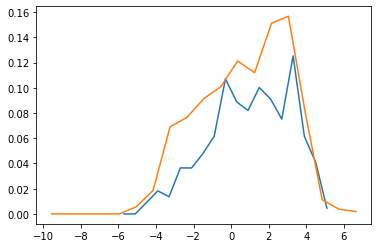

In [22]:
plt.plot(pX_mutil.get_axes(2)[0], pX_mutil.get_conditional(2,1,sample_dict={1:1.0}))
plt.plot(pX_synthetic_mutil.get_axes(2)[0], pX_synthetic_mutil.get_conditional(2,1,sample_dict={1:1.0}))
pass;

In [23]:
def Pi_UNj_DOk(i, j, k, sampler):
    do = np.zeros(sampler.get_joint(i, k).shape)
    latent = sampler.get_joint(j)
    
    for n in range(len(latent)):
        do += sampler.get_conditional(i, j, k)[:,n,:]*latent[n]
    return do

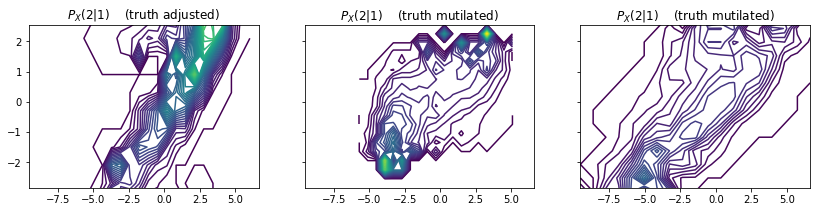

In [24]:
fig, axs = plt.subplots(1, 3, sharex='row', sharey='row', figsize = (14,3))
axs[0].set_ylim(np.amin(pX_mutil.get_axes(1)[0]), np.amax(pX_mutil.get_axes(1)[0]))

axs[0].set_title(r'$P_X(%s|%s)$    (truth adjusted)'%(2, 1))
axs[0].contour(*np.meshgrid(*pX.get_axes(2, 1)), Pi_UNj_DOk(2, 0, 1, pX).T, levels=50)
axs[1].set_title(r'$P_X(%s|%s)$    (truth mutilated)'%(2, 1))
axs[1].contour(*pX_mutil.get_contour_conditional(2, 1), levels=50)
axs[2].set_title(r'$P_X(%s|%s)$    (truth mutilated)'%(2, 1))
axs[2].contour(*pX_synthetic_mutil.get_contour_conditional(2, 1), levels=50)
pass;

In [25]:
# stone_data = np.array([[[0.], [0.], [1.]]]*84 + 
#                       [[[0.], [0.], [0.]]]*(87-84) + 
#                       [[[0.], [1.], [1.]]]*234 + 
#                       [[[0.], [1.], [0.]]]*(270-234) + 
#                       [[[1.], [0.], [1.]]]*192 + 
#                       [[[1.], [0.], [0.]]]*(263-192) + 
#                       [[[1.], [1.], [1.]]]*55 + 
#                       [[[1.], [1.], [0.]]]*(80-55))

# prob2 = sampler(stone_data, bin_width = 1., discrete = True)
# prob2.get_conditional([2],[0])[1,:]
# prob2.get_conditional([2],[1])[1,:]
# prob2.joints

# prob2.get_conditional([2],[0,1])[:,0,0]*prob2.joints[(0,)]['joint'][0] + \
# prob2.get_conditional([2],[0,1])[:,1,0]*prob2.joints[(0,)]['joint'][1]

# prob2.get_conditional([2],[0,1])[:,0,1]*prob2.joints[(0,)]['joint'][0] + \
# prob2.get_conditional([2],[0,1])[:,1,1]*prob2.joints[(0,)]['joint'][1]

# prob2.get_conditional([2],[0,1])[:,0,:]*prob2.joints[(0,)]['joint'][0] + \
# prob2.get_conditional([2],[0,1])[:,1,:]*prob2.joints[(0,)]['joint'][1]

In [26]:
# shd_trials

#### noise = 0.1
# [5, 5, 3, 3, 5, 3, 7, 4, 5, 6, 6, 3, 4, 3, 5, 3, 4, 6, 4, 4]
# 4.4 +- 1.2
# [5, 3, 3, 2, 5, 5, 5, 7, 4, 2, 3, 2, 4, 4, 5, 4, 3, 4, 5, 4]
# 3.95 +- 1.24

#### noise = 0.3
# [1, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 1, 2, 3]
# 2.05 +- 0.589

#### noise = 0.5
# [1, 1, 3, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0]
# 1.2 +- 0.60

#### noise = 0.7
# [0, 1, 0, 1, 1, 3, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1]
# 0.65 +- 0.726

In [27]:
# shd_trials
# np.mean(shd_trials)
# np.std(shd_trials)

####### node_dict = {0:[0,1], 1:[2,3,4], 2:[5,6]}
#### noise = 0.05
### h_A experiments
# [9, 9, 11, 9, 9, 10, 9, 6, 9, 7]
# 8.8 +- 1.32664991614216
### h_A_ordered experiments
# [2, 6, 7, 5, 5, 4, 6, 7, 6, 6]
# 5.4 +- 1.42828568570857

#### noise = 0.1
### h_A experiments
# [7, 8, 7, 9, 8, 8, 4, 9, 5, 8]
# 7.3 +- 1.5524174696260025
### h_A_ordered experiments
# [1, 1, 5, 4, 4, 4, 4, 5, 3, 1]
# 3.2 +- 1.5362291495737217